## Problem 1: Online Updating for Least Squares and Autoregressive Time Series Models

Many applications of least squares (and other statistical methods)
involve \emph{streaming data}, in which data is collected over a time
period and the statistical model is updated as new data arrives. If
the quantity of data arriving is very large, it may be inefficient or even impossible to
refit the entire model on the entire dataset. Instead, we use
techniques (often referred to as \emph{online learning} which take the current model as a starting point and
update them to incorporate the new data.

The structure of least squares problems makes them amenable to online updating (sometimes this is called "recursive" least squares).
The structure of the problem is as follows, at time $t$ we receive a vector of observations $\mathbf{a}_t$ and an observation of our
target variable $b_t$.

The full set of all observations and target variable data that we have received up to time $t$ is contained in the following matrix and vector:

$$
A_{(t)} = \begin{bmatrix} \cdots\, \mathbf{a}_1^T\, \cdots \\
\cdots\, \mathbf{a}_2^T\, \cdots \\ \vdots \\ \cdots\, \mathbf{a}_t^T\, \cdots \end{bmatrix},\quad
\mathbf{b}_{(t)} = \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_t \end{bmatrix}
$$



which says that row $j$ of the matrix $A_{(t)}$ is the $j$th observation $\mathbf{a}_j^T$, and the $j$th entry of $\mathbf{b}_{(t)}$ is $b_j$.


Here we assume that the vectors $\mathbf{a}$ each contain $n$ observations, so that $A_{(t)}$ is a $t\times n$ matrix and the vector
$\mathbf{b}_{(t)}$ is a $t$-vector.

As long as $t>n$, i.e. the number of time observations is greater than the number of features/data points in each observation, we can fit a linear model predicting the target
as a function of the features $\mathbf{a}$ by solving the following system of equations:

$$
(A^T_{(t)}A_{(t)})\mathbf{x}_{(t)} = A_{(t)}^T\mathbf{b}_{(t)}
$$

As the length of the time series increases, the computational difficulty of solving this problem also increases. However, it is possible to re-use work done on the previous
time step to avoid solving the full system at each step.

This algorithm is based on the fact that the _Gram Matrix_ $A^T_{(t+1)}A_{(t+1)}$ can be calculated from the Gram matrix $A^T_{(t)}A_{(t)}$ from the previous time step.
$$
A^T_{(t+1)}A_{(t+1)} = A^T_{(t)}A_{(t)} + \mathbf{a}_{t+1}\mathbf{a}_{t+1}^T
$$
Similarly, the product $A^T_{(t+1)} \mathbf{b}_{(t+1)}$ can also be updated from the
value on the previous time step:
$$
A^T_{(t+1)}\mathbf{b}_{(t+1)} = A^T_{(t)}\mathbf{b}_{(t)} + b_{t+1}\mathbf{a}_{t+1}
$$

We can write an efficient algorithm to compute the updated least squares solution as follows:

- Step 1: Pick an initial time $t$ such that $A_{t}$ is square or tall so that the
least squares problem can be solved (i.e. wait for enough data to have built up before your start) and then calculate the Gram matrix and the product $A^T_{t} \mathbf{b}_t$
$$
G_{(t)} = A^T_{(t)}A_{(t)}, \quad \mathbf{h}_{(t)} = A^T_{t}\mathbf{b}_t
$$
- Step 2: Find the least squares solution at time $t$ by solving the linear
system:
$$
G_{(t)}\mathbf{x}_{(t)} = \mathbf{h}_{(t)}
$$

- Step 3: When the next data points $\mathbf{a}_{t+1}$ and $b_{t+1}$, update
$G_{(t+1)}$ and $\mathbf{h}_{(t+1)}$:

$$ G_{(t+1)} = G_{(t)} + \mathbf{a}_{t+1}\mathbf{a}^T_{t+1},\quad
\mathbf{h}_{(t+1)} = \mathbf{h}_{(t)} + b_{t+1}\mathbf{a}_{t+1}
$$
Then you can repeat Step 2 to find $\mathbf{x}_{t+1}$. This algorithm can be improved upon slightly using the Matrix Inversion Lemma/Woodbury Formula, which could be a topic for a project (see note at the end which mentions Kalman filters).


(a) You are going to use this algorithm to make a linear, autoregressive model that predicts total day-ahead citibike trips from the daily high temperature and the number of daily citibike trips taken each of the past 7 days. The data is contained in the file [daily_citibike_trips.csv](https://github.com/georgehagstrom/DATA609Spring2025/blob/main/website/assignments/labs/labData/daily_citibike_trips.csv).

Specifically, for each time point $t>7$ , fit the following
model as a least squares estimation problem:
$$
N_{trips,\tau} = \sum_{i=1}^7 C_i N_{trips,\tau-i} + C_T T,
$$
Here, each $N_{trips,\tau}$ stands for the number of citibike trips on the $t$th day of the time series, $T$ stands for the forecast high temperature in New York City that day, and the coefficients $C_i$ and $C_T$ are the decision variables.

Find the coefficients $C_{i,t}$ and $C_{T,t}$ that minimize the mean square errors on all the observed citibike trips prior to time $t$. Use the recursive least squares optimization outlined in the preamble to this problem to calculate the coefficients for each time point, and plot how they and the $R^2$ of the model change over time.

What patterns do you notice in how the regression coefficients and $R^2$ change over time?

Tip: Be very cautious when coding about the dimensionality of matrices and arrays.
In python, `a @ a.T` will be an 8x8 matrix if `a.shape = (8,1)`. However, by default
`a.shape = (8,)`, indicating that `a` is not being treated as either a row or column vector. For this problem it is important that the vectors are either row or column vectors, and not arrays without such an orientation. In python, you can use `numpy.reshape` to adjust.

**Solution:**

**Step 1.** First, for each time t, we are going to create a feature vector $\mathbf{a}_t$ (8 rows, 1 column, each row has info about past 7 days of trips and temperature for day t), a target vector $b_t$ (the number of trips on day t) and coefficient vector $\mathbf{x}_t$ (8 rows, 1 column, each row has a coefficient at time t). The data matrix $A_t$ is a tx8 matrix (since $\mathbf{a}_t$ has 8 features), we should remember that the number of time observations is greater than the number of features/data points in each observation in order to fit a linear model. We start at day 8 as the previous 7 days are used to form $\mathbf{a}_8$. In Python, we load the dataset and create lag features for the past 7 days:

$$
\mathbf{a}_t = [N_{trips, t-1}, N_{trips, t-2}, \cdots\ , N_{trips, t-7}, T_t]^T, \\
b_t=N_{trips,t}, \\
\mathbf{x}_t = [C_{1,t}, C_{2,t},  \cdots,  C_{7,t},  C_{T,t}]^T, \\
A_{(t)} = \begin{bmatrix} \cdots\, \mathbf{a}_8^T\, \cdots \\
\cdots\, \mathbf{a}_9^T\, \cdots \\ \vdots \\ \cdots\, \mathbf{a}_t^T\, \cdots \end{bmatrix},\quad
\mathbf{b}_{(t)} = \begin{bmatrix} N_{trips, 8} \\ N_{trips, 9} \\ \vdots \\ N_{trips, t} \end{bmatrix}
$$

Next, we create the Gram matrix $G_t$ and vector $h_t$:
$$
G_{(t)} = A^T_{(t)}A_{(t)}, \quad \mathbf{h}_{(t)} = A^T_{t}\mathbf{b}_t.
$$

**Step 2.**  Find the least squares solution at time $t$ by solving the linear
system:
$$
G_{(t)}\mathbf{x}_{(t)} = \mathbf{h}_{(t)}
$$

**Step 3.** We apply reccursive updated to the Gram matrix $G_t$ and vector $h_t$ and solve the updated system:

$$ G_{(t+1)} = G_{(t)} + \mathbf{a}_{t+1}\mathbf{a}^T_{t+1},\quad \\
\mathbf{h}_{(t+1)} = \mathbf{h}_{(t)} + b_{t+1}\mathbf{a}_{t+1}, \\
G_{(t+1)}\mathbf{x}_{(t+1)} = \mathbf{h}_{(t+1)}.
$$

In Python, we update for each new data point $G_{(t+1)}, \mathbf{h}_{(t+1)}$, and solve for updated coefficients $\mathbf{x}_{(t+1)}$. After, we store coefficients and compute $R^2$ to track model performance.

The strongest weight is on $C_T$=68.65, temperature has a large positive impact on trip counts. The previous day’s trip count $C_1$=0.45 is the most influential past trip variable as earlier days have decreasing weight, older data becomes less relevant for prediction.

**Step  4.** Plot coefficient trajectories over time to observe how they stabilize, and $R^2$ over time to evaluate model accuracy.

Initially, there are fluctuations in  coefficient trajectories as the model adapts to new data, but the coefficients stabilize as more data is incorporated. For the second plot, $R^2$ is initially volatile due to limited data. As more observations are incorporated, $R^2$ improves and stabilizes around 0.84, indicating a good fit.


In [263]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

In [264]:
#Load dataset from Github
data = pd.read_csv('https://media.githubusercontent.com/media/georgehagstrom/DATA609Spring2025/refs/heads/main/website/assignments/labs/labData/daily_citibike_trips.csv')
data.head(), data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3949 entries, 0 to 3948
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         3949 non-null   object
 1   daily_trips  3949 non-null   int64 
 2   TMAX         3949 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 92.7+ KB


(         date  daily_trips  TMAX
 0  2013-05-31          362    90
 1  2013-06-01         8959    90
 2  2013-06-02        15467    88
 3  2013-06-03         7700    78
 4  2013-06-04        15849    75,
          daily_trips         TMAX
 count    3949.000000  3949.000000
 mean    53911.858698    63.637377
 std     33089.106922    17.890984
 min       249.000000    13.000000
 25%     29361.000000    49.000000
 50%     46198.000000    65.000000
 75%     73102.000000    79.000000
 max    161586.000000    98.000000,
 None)

In [265]:
#Step 1
bike_df = data.copy()
#Number of features, 7 previous days and temperature
n_features = 8
#Number of past days to consider
start_day = n_features

#Data for the previous 7 days
for i in range(1, start_day):
    bike_df[f'lag_{i}'] = bike_df['daily_trips'].shift(i)

#If any NAs
bike_df = bike_df.dropna().reset_index(drop=True)
#8 features for a
features = [f'lag_{i}' for i in range(1, start_day)] + ['TMAX']
X = bike_df[features].values
y = bike_df['daily_trips'].values.reshape(-1, 1)

#Start values
start_size = n_features
start_A = X[:start_size, :]
start_b = y[:start_size]

# Gram matrix, h vector
G = start_A.T @ start_A
h = start_A.T @ start_b

#Step 2
#Solution of initial least squares problem
x = np.linalg.solve(G, h)

#Step 3
#Keep regression coefficients
coeff_info = [x.flatten()]
r2_info = []

# Step 3: Online Recursive Update
for t in range(start_size, len(y)):
    a_t = X[t, :].reshape(-1, 1)
    b_t = y[t, 0]

    # Update Gram matrix and h vector
    G += a_t @ a_t.T
    h += b_t * a_t

    #Solve updated system
    x = np.linalg.solve(G, h)

    #Keep and compute R^2
    coeff_info.append(x.flatten())
    coeff_info_arr = np.array(coeff_info)
    y_pred = X[:t+1, :] @ x
    ss_total = np.sum((y[:t+1] - np.mean(y[:t+1])) ** 2)
    ss_residual = np.sum((y[:t+1] - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    r2_info.append(r2)
    r2_info_arr = np.array(r2_info).reshape(-1, 1)

The coefficients C_{i,t} and C_{T,t} that minimize the mean square errors on all the observed citibike trips prior to time t:  [[4.52631814e-01]
 [2.49456896e-02]
 [5.73475787e-02]
 [4.94046916e-02]
 [5.95294284e-02]
 [1.03694620e-01]
 [1.81216683e-01]
 [6.86537452e+01]]


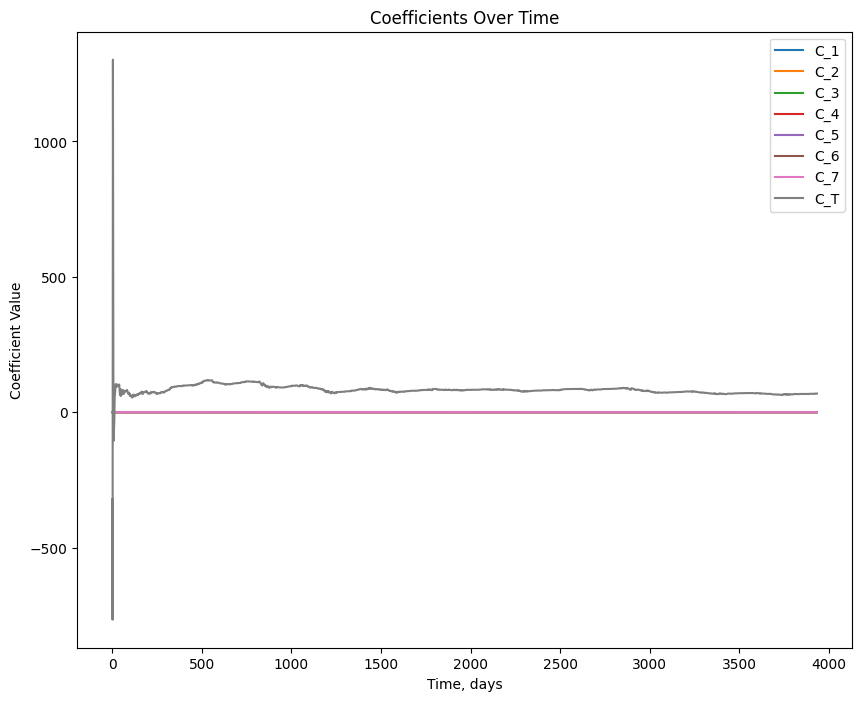

<ipython-input-266-e84fbdf49eb1>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


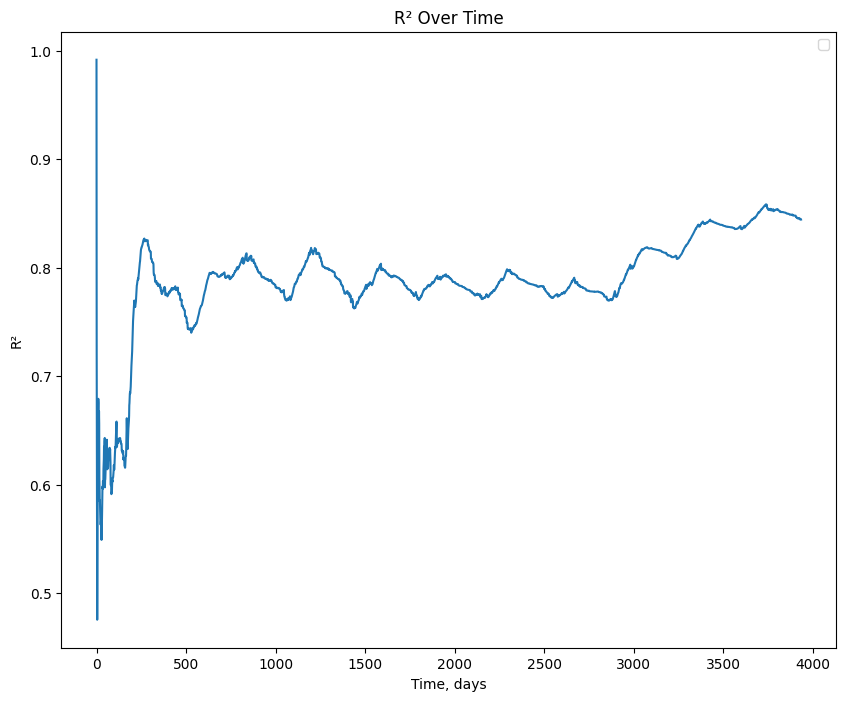

Final temperature coefficient: 68.65374516087334
Final R²: 0.8442976618813519


In [266]:
print("The coefficients C_{i,t} and C_{T,t} that minimize the mean square errors on all the observed citibike trips prior to time t: ", x)

#Step 4, plot coeff and r^2
plt.figure(figsize=(10, 8))
for i in range(n_features):
    plt.plot(coeff_info_arr[:, i],label=f'C_{i+1}' if i <7 else 'C_T')
plt.xlabel('Time, days')
plt.ylabel('Coefficient Value')
plt.title('Coefficients Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(r2_info_arr)
plt.xlabel('Time, days')
plt.ylabel('R²')
plt.title('R² Over Time')
plt.legend()
plt.show()

#Final temperature coefficient and R^2
final_temp_coeff = x[-1, 0]
final_r2 = r2_info_arr[-1, 0]
print("Final temperature coefficient:",final_temp_coeff)
print("Final R²:", final_r2)

(b) We have included temperature as a variable because it probably influences the decision to ride a citibike. However, the relationship could be nonlinear, as both extreme high and low temperatures make bike riding less comfortable. With this idea in mind, create
a new feature by choosing a nonlinear function of the temperature $T$ that represents
the potential for both high and low values of $T$ to the same impact on predicted
ridership. Use least squares optimization to fit an autoregressive time series model, replacing $T$ with the value of your
new feature $f(T)$ in the time series. How does the temperature dependence coefficient differ between this model and the one you fit in (a)? Does the accuracy of the model improve or get worse using the new feature?

We can implement new feature via comparison with some base temperature $T_0$ (for example, 65 as the median temperature) and make it non-linear by using power of 2:
$f(T) = (T-T_0)^2.$

We are going to use the same recursive least squares approach as in part (a), but  replace $T$ with $f(T)$. In part (a), the temperature coefficient was 68.65 (a strong positive correlation between temperature and daily trips). In part (b), the new temperature coefficient after the nonlinear transformation $C_T=-1.74$, the extreme temperatures or a deviation from the median reduce bike usage. In part (a) and (b), the final $R^2$ was the same 0.8443, using the transformed feature did not improve the model’s ability to explain variance in the data, the linear model already captured most of the variability. Further, we could try other nonlinear transformations (exponential, sigmoid, etc) to see how they affect model's performance.

In [267]:
#Implement non-linear temperature
T_o = bike_df['TMAX'].median()
bike_df['T_transformed'] = (bike_df['TMAX'] - T_o) ** 2

#8 features for a with new T
features_new = [f'lag_{i}' for i in range(1, start_day)] + ['T_transformed']
X_new = bike_df[features_new].values
y_new = bike_df['daily_trips'].values.reshape(-1, 1)

#Start values
start_size = n_features
start_A = X_new[:start_size, :]
start_b = y_new[:start_size]

# Gram matrix, h vector
G_new = start_A.T @ start_A
h_new = start_A.T @ start_b

#Step 2
#Solution of initial least squares problem
x_new = np.linalg.solve(G_new, h_new)

#Step 3
#Keep regression coefficients
coeff_info_new = [x_new.flatten()]
r2_info_new = []

# Step 3: Online Recursive Update
for t in range(start_size, len(y_new)):
    a_t = X_new[t, :].reshape(-1, 1)
    b_t = y_new[t, 0]

    # Update Gram matrix and h vector
    G_new += a_t @ a_t.T
    h_new += b_t * a_t

    #Solve updated system
    x_new = np.linalg.solve(G_new, h_new)

    #Keep and compute R^2
    coeff_info_new.append(x_new.flatten())
    y_pred_new = X_new[:t+1, :] @ x_new
    ss_total = np.sum((y_new[:t+1] - np.mean(y_new[:t+1])) ** 2)
    ss_residual = np.sum((y_new[:t+1] - y_pred_new) ** 2)
    r2_new = 1 - (ss_residual / ss_total)
    r2_info_new.append(r2)

coeff_info_arr_new = np.array(coeff_info_new)
r2_info_arr_new = np.array(r2_info_new).reshape(-1, 1)

The coefficients C_{i,t} and C_{T,t} that minimize the mean square errors on all the observed citibike trips prior to time t:  [[ 0.4719551 ]
 [ 0.03495606]
 [ 0.06626496]
 [ 0.05770381]
 [ 0.06877473]
 [ 0.11162964]
 [ 0.18942578]
 [-1.73857289]]


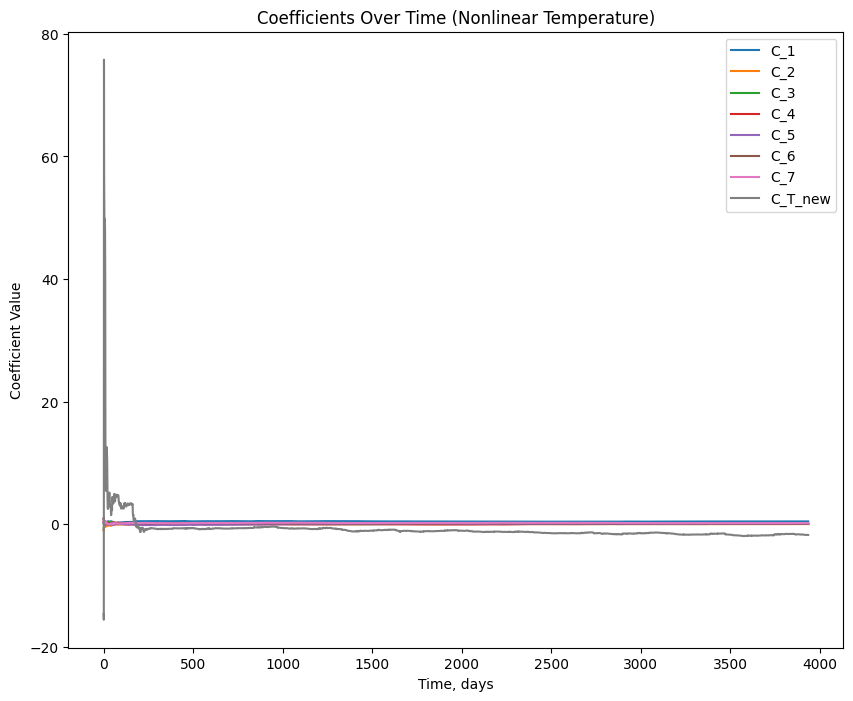

<ipython-input-268-9e9f979b1012>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


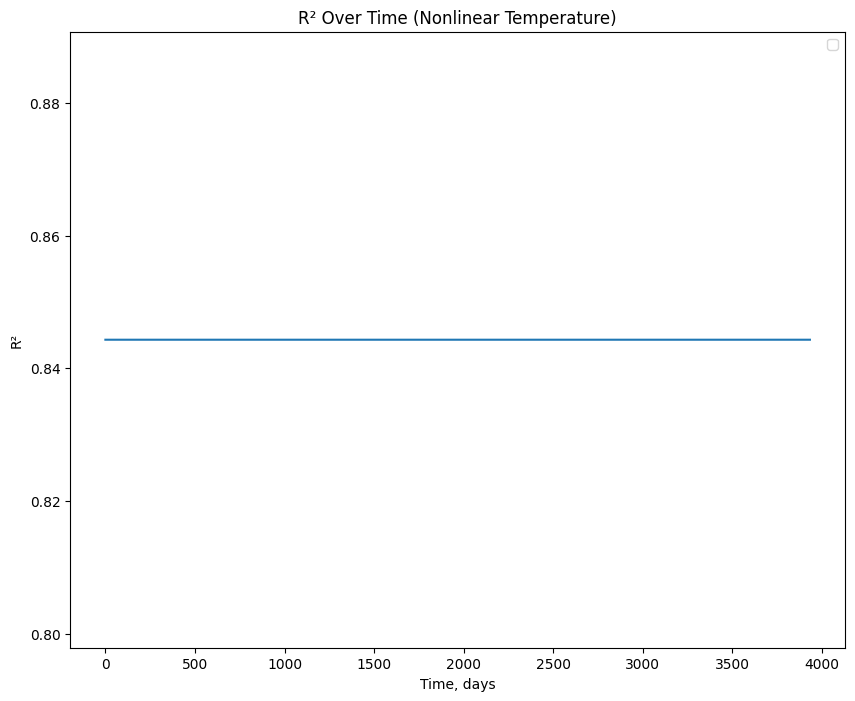

Final temperature coefficient (nonlinear model): -1.738572885675982
Final R² (nonlinear model): 0.8442976618813519


In [268]:
print("The coefficients C_{i,t} and C_{T,t} that minimize the mean square errors on all the observed citibike trips prior to time t: ", x_new)
#Step 4, plot coeff and r^2
plt.figure(figsize=(10, 8))
for i in range(n_features):
    plt.plot(coeff_info_arr_new[:, i],label=f'C_{i+1}' if i <7 else 'C_T_new')
plt.xlabel('Time, days')
plt.ylabel('Coefficient Value')
plt.title('Coefficients Over Time (Nonlinear Temperature)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(r2_info_arr_new)
plt.xlabel('Time, days')
plt.ylabel('R²')
plt.title('R² Over Time (Nonlinear Temperature)')
plt.legend()
plt.show()

#Final temperature coefficient and R^2
final_temp_coeff_new = x_new[-1, 0]
final_r2_new = r2_info_arr_new[-1, 0]
print("Final temperature coefficient (nonlinear model):",final_temp_coeff_new)
print("Final R² (nonlinear model):", final_r2_new)

## Problem 2: Weighted Least Squares

The file [social-mobility.csv](https://github.com/georgehagstrom/DATA609Spring2025/blob/main/website/assignments/labs/labData/social_mobility.csv) contains data on the fraction of
individuals born in the years 1980-1982 to parents in the bottom 20\% of the income distribution who reach the top 20\% of the income distribution by the time they turn 30 in a large number of municipalities throughout the United States. The dataset also contains
additional variables that describe other socio-economic differences
between the cities in the dataset.

(a) Make a scatter-plot of mobility versus population (use a log-scale for population). What do you notice about the variance of social mobility as a function of population? This is a common feature of nearly every dataset containing geographic regions with widely different populations.

**Solution:** After constructing the Mobility vs. Population plot (log scale), we noticed that the variance of social mobility decreases as population increases: data points are more dispersed on the left, between 0.025 and 0.35 (where the population is lower), and more tightly clustered on the right, approximately between 0.025 and 0.125 (where the population is higher).

From this plot, we might think that social mobility is lower in larger cities. However, outliers exist, as some small cities exhibit low mobility, while some large cities have unexpectedly high mobility.

In [269]:
#Load dataset from Github
data = pd.read_csv('https://media.githubusercontent.com/media/georgehagstrom/DATA609Spring2025/refs/heads/main/website/assignments/labs/labData/social_mobility.csv')
data.head(), data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     711 non-null    int64  
 1   Name                   711 non-null    object 
 2   Mobility               699 non-null    float64
 3   State                  711 non-null    object 
 4   Population             711 non-null    int64  
 5   Student_teacher_ratio  711 non-null    float64
 6   Commute                711 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 39.0+ KB


(    ID              Name  Mobility State  Population  Student_teacher_ratio  \
 0  301    Middlesborough  0.072635    TN       66708                   15.1   
 1  401     Winston-Salem  0.044801    NC      493180                   15.4   
 2  500        Greensboro  0.047397    NC     1055133                   16.7   
 3  601  North Wilkesboro  0.051663    NC       90016                   16.2   
 4  602             Galax  0.079570    VA       64676                   12.3   
 
    Commute  
 0    0.359  
 1    0.292  
 2    0.305  
 3    0.289  
 4    0.325  ,
                  ID    Mobility    Population  Student_teacher_ratio  \
 count    711.000000  699.000000  7.110000e+02             711.000000   
 mean   23020.302391    0.101852  3.763665e+05              16.507314   
 std    10892.268091    0.053174  1.052768e+06               2.429247   
 min      301.000000    0.022102  1.193000e+03               9.600000   
 25%    13551.000000    0.067456  3.659300e+04              14.90000

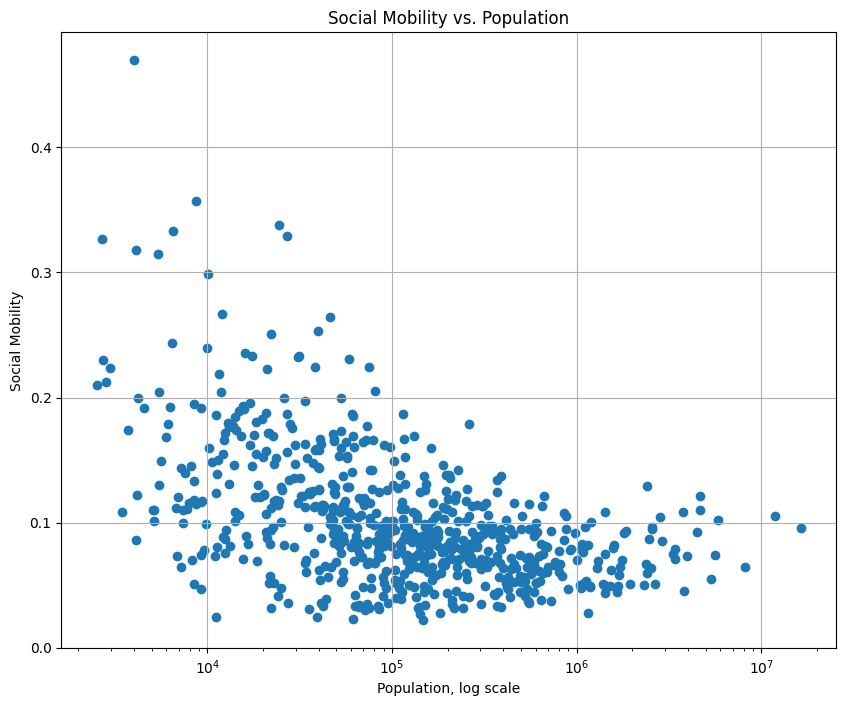

In [270]:
#Scatter plot mobility vs population
mobility_df = data.copy()
plt.figure(figsize=(10, 8))
plt.scatter(mobility_df['Population'], mobility_df['Mobility'])
plt.xscale('log')
plt.xlabel('Population, log scale')
plt.ylabel('Social Mobility')
plt.title('Social Mobility vs. Population')
plt.grid(True)
plt.show()

(b) Assume that the number of children born in families making below the 20th percentile of the income distribution in each city is linearly proportional to the city population. Write down a formula
for how the variance of each measurement of the social mobility should depend
on the measured social mobility and the population. Hint: start with
either the formula for the variance of binomial counts or look up the
variance of a proportion derived from a binomial distribution. Don't
worry about constant factors when deriving this formula.

**Solution:** We assume a binomial distribution, assuming that the number of children born to families in the bottom 20% of the income distribution in each city is linearly proportional to the city population.

Let $N$ be the city population, $k*N$ be the number of children born in the bottom 20% of the income distribution (where k is a constant of proportionality), $p$ be the measured social mobility, which represents the probability of an individual moving from the bottom 20% to the top 20%. Since the number of successful transitions follows a binomial distribution:

$$X \propto \text{Binomial}(kN,p)$$

The variance of a binomial random variable is $$Var(X) = kNp(1 - p)$$.

Since social mobility is measured as a proportion:

$$p = \frac{X}{kN}, \\
Var(p) = Var(\frac{X}{k N}) = \frac{1}{(kN)^2} \cdot \text{Var}(\text{X}), \\
Var(p) = \frac{1}{(k \cdot N)^2} \cdot (k \cdot N \cdot p \cdot (1 - p)) = \frac{p \cdot (1 - p)}{k \cdot N}.$$

The variance of social mobility is proportional to the following expression, as
k is an unknown constant:
$$\text{Variance} \propto \frac{\text{Mobility} \cdot (1 - \text{Mobility})}{\text{Population}}.$$

In [271]:
#variance estimate
mobility_df['Variance'] = (mobility_df['Mobility'] * (1 - mobility_df['Mobility'])) / mobility_df['Population']

#weights as the inverse of variance
mobility_df['Weight'] = 1 / mobility_df['Variance']

#remove invalid entries
mobility_df = mobility_df.dropna(subset=['Variance'])  # Remove NaN values
mobility_df = mobility_df[mobility_df['Variance'] > 0]  # Remove zero variance cases

mobility_df[['Mobility', 'Population', 'Variance', 'Weight']].head()

,Mobility,Population,Variance,Weight
0,0.072635,66708,1.009763e-06,9.903313e+05
1,0.044801,493180,8.677092e-08,1.152460e+07
2,0.047397,1055133,4.279126e-08,2.336926e+07
3,0.051663,90016,5.442816e-07,1.837284e+06
4,0.079570,64676,1.132391e-06,8.830872e+05


(c) Use weighted least squares to calculate an estimate of how
social mobility depends on commute time and student-teacher ratio, using weights calculated based on the variance estimate derived in (b).
Compare the coefficients to those derived from ordinary least squares with no weights.

**Solution:**

For OLS, the coefficient for commute time is 0.2118 (highly significant, p<0.001),

for student-teacher ratio is -0.0019 (significant, p=0.014),

intercept is 0.036 (significant,p=0.027),

$R^2$ is 0.356 (moderate explanatory power).


For WLS: The coefficient for
commute time is 0.0624 (highly significant, p<0.001),


for student-teacher ratio is 0.0031 (significant, p<0.001, opposite sign from OLS),

intercept is −0.0025 (not significant, p=0.776),

$R^2$ is 0.095 (much lower than OLS, WLS models less variance).


The OLS model estimates much stronger effects for commute time and a slightly negative effect for student-teacher ratio. OLS overestimates commute time’s importance. The WLS model, which accounts for variance heterogeneity, shows smaller coefficients. Commute time still positively influences mobility but with a lower effect. Student-teacher ratio changes sign to a small positive value, indicating that when correcting for variance, its effect might be different from what OLS suggests.
Weighting leads to a large drop in $R^2$ (from 0.356 to 0.095).


As a result, OLS may overstate effects due to uncorrected variance differences across cities. WLS gives a more reliable estimation by correcting for population-dependent variance, but the predictive power drops.
Commute time and student-teacher ratio still significantly affect social mobility, but their impact is more nuanced when properly weighted.

In [272]:
#Independent variables, intercept
X = mobility_df[['Commute', 'Student_teacher_ratio']]
X = sm.add_constant(X)

#Dependent variable
y = mobility_df['Mobility']

#OLS regression
ols_model = sm.OLS(y, X).fit()

#WLS regression using computed weights
wls_model = sm.WLS(y, X, weights=mobility_df['Weight']).fit()

#Summary of both models
ols_summary = ols_model.summary()
wls_summary = wls_model.summary()

ols_summary, wls_summary

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               Mobility   R-squared:                       0.356
 Model:                            OLS   Adj. R-squared:                  0.354
 Method:                 Least Squares   F-statistic:                     192.6
 Date:                Mon, 24 Feb 2025   Prob (F-statistic):           2.72e-67
 Time:                        04:37:30   Log-Likelihood:                 1213.6
 No. Observations:                 699   AIC:                            -2421.
 Df Residuals:                     696   BIC:                            -2408.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------

# Problem 3: Markowitz Portfolio Optimization

In this problem you will use _Markowitz Portfolio Optimization_ to construct a set of portfolios that aim to achieve target expected rates of return while minimizing risk. The file [stock_returns.csv](https://github.com/georgehagstrom/DATA609Spring2025/blob/main/website/assignments/labs/labData/stock_returns.csv) contains information on daily asset returns from 2020-2024 for a group of assets, consisting mostly of large-cap stocks but also a handful of exchange traded funds that correspond to US Treasury Bonds and Notes with varying maturities.

You will divide the data into two time periods, a training period (2020-2022) and a testing period (2022-2024). The data in the `stock_returns.csv` is stored in a long format, with the
following variables:

  1. `Company` - The ticker symbol that identifies the stock
  2. `date` - The date to which the data corresponds
  3. `adjusted`- the closing price of the stock, adjusted for special events like   dividends and stock splits
  4. `return` - the ratio of the current adjusted close to the adjusted close on the previous trading day
  5. `log_return`- the natural logarithm of the return


(a)  Construct a vector (we call it $\mu$) containing the annualized rate of return over the training period (for the $i$th stock, you can use the formula: $\mu_i = \exp\left(0.5\sum_{t} \mathrm{log\_return}_i(t)\right)$), or the square root of the total return over the first two years of data,  and daily return covariance
$\Gamma$.

__Hint__: Possible workflow if  working in python: convert your data to a wide format using `pandas`, extract the values into a `numpy ndarray`, and then use the function `np.cov`.

Then solve the following constrained least squares problem
to calculate optimal portfolios achieving a fixed rate of return
with minimum variance:

$$
\begin{aligned}
    \min_{w} \mathbf{x}^T\Gamma \mathbf{x}, \\
    \mathbf{w}^T\mathbf{\mu} = r, \\
    \sum_{i} w_i = 1
\end{aligned}
$$
Here $\mathbf{w}$ is a vector containing the investment allocations into different
assets, and $r$ is the target rate of return.

Calculate optimal portfolios based on the 2020-2022 data for $r=1.05$, $r=1.10$, and $r=1.20$.

**Solution:**

First, we load the dataset, convert it into a DataFrame, and split the data into a training period (2020–2022) and a testing period (2023–2024). We use the training data to estimate $\mu$ and $\Gamma$, aand the testing data for validation. After splitting the data, we pivot training data to wide format where each column corresponds to one asset’s daily log returns, and each row corresponds to a trading day.

Next, we construct a vector $\mu$ a one-dimensional array whose length is equal to the number of assets, containing the annualized rate of return over the training period. In Python, we also extract values into numpy ndarray after using the formula:

$$\mu_i = \exp\left(0.5\sum_{t} \mathrm{log\_return}_i(t)\right).$$

We compute the covariance matrix $\Gamma$ using daily log returns. In Python, we apply np.cov() to the values in the wide-format training dataset. The resulting matrix has dimensions equal to the number of assets x the number of assets:

$$\Gamma = \mathrm{cov}(\mathrm{log\_return}).$$

As the last step, we solve the optimization proble using the formulas from the problem statement. In Python, we can use scipy.optimize() with the Sequential Least Squares Programming (SLSQP, commonly used for solving constrained optimization problems) method to solve this problem. The portfolio variance is defined by $\mathbf{w}^T\Gamma \mathbf{w}$. The constraint $\mathbf{w}^T\mathbf{\mu} = r$ iensures that the portfolio achieves the target return, while $\sum_{i} w_i = 1$ enforces a fully invested portfolio by requiring that all weights sum to 1. In most portfolio optimization problems, weight bounds are enforced, typically restricting each weight to be between 0 and 1 (i.e., no short-selling). However, since the problem statement does not specify such constraints, we allow short selling in this implementation. The starting point of the optimization is equal weights (1/len($\mathbf{\mu}$)). We then call the portfolio_optimize function for three target returns: 1.05, 1.10, and 1.20. Each call returns a weight vector $\mathbf{w}$. The results are printed below. We verify that the sum of weights for each target return is equal to 1 and that the portfolio’s expected annualized return closely matches the specified target. Some weights may be negative (indicating short positions) because we have not enforced non-negativity constraints.

In [273]:
#Load dataset from Github
data = pd.read_csv('https://media.githubusercontent.com/media/georgehagstrom/DATA609Spring2025/refs/heads/main/website/assignments/labs/labData/stock_returns.csv')
#Convert to df
data['date'] = pd.to_datetime(data['date'])

#Split to train and test
stock_df = data.copy()
train_df = stock_df[(stock_df['date'] >= '2020-01-01') & (stock_df['date'] <= '2022-12-31')]
test_df = stock_df[(stock_df['date'] >= '2023-01-01') & (stock_df['date'] <= '2024-12-31')]

data.head(), data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592047 entries, 0 to 592046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Company     592047 non-null  object        
 1   date        592047 non-null  datetime64[ns]
 2   adjusted    592047 non-null  float64       
 3   return      592047 non-null  float64       
 4   log_return  592047 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 22.6+ MB


(  Company       date   adjusted    return  log_return
 0    AAPL 2020-01-02  72.796028  1.022817    0.022560
 1    AAPL 2020-01-03  72.088295  0.990278   -0.009770
 2    AAPL 2020-01-06  72.662704  1.007968    0.007937
 3    AAPL 2020-01-07  72.320969  0.995297   -0.004714
 4    AAPL 2020-01-08  73.484352  1.016086    0.015958,
                                 date       adjusted         return  \
 count                         592047  592047.000000  592047.000000   
 mean   2022-06-30 22:13:27.637231360     155.893055       1.000691   
 min              2020-01-02 00:00:00       0.979024       0.470926   
 25%              2021-04-01 00:00:00      41.990664       0.990436   
 50%              2022-06-30 00:00:00      85.252342       1.000618   
 75%              2023-09-29 00:00:00     171.392616       1.010869   
 max              2024-12-30 00:00:00    9924.400391       1.665000   
 std                              NaN     338.845444       0.023503   
 
           log_return  
 cou

In [274]:
#Pivot to wide format, shape: number of trading days x stocks
train_wide = train_df.pivot(index='date', columns='Company', values='log_return')
test_wide = test_df.pivot(index='date', columns='Company', values='log_return')

#mu, a vector containing the annualized rate of return over the training period
mu = np.exp(0.5 * train_wide.sum())
mu = mu.values

#Covariance matrix, rowvar=False - columns are variables
Gamma = np.cov(train_wide.values, rowvar=False)

isinstance(mu, np.ndarray), isinstance(Gamma, np.ndarray), len(mu), len(Gamma)

(True, True, 471, 471)

In [275]:
def portfolio_optimize(mu, Gamma, target_return):
    #Variance
    def portfolio_var(w):
        return w.T @ Gamma @ w

    #Constraints, weights should sum to 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: w.T @ mu - target_return},
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    ]

    #Each weight must be between 0 and 1
    n_companies = len(mu)

    #Initial condition
    initial_cond = np.array([1/n_companies] * n_companies)

    bounds = tuple((None, None) for _ in range(n_companies))

    #The optimization problem
    result = minimize(portfolio_var, initial_cond, bounds = bounds, method='SLSQP', constraints=constraints)

    return result.x

#Solve for a target return of 1.05 (5% above baseline)
target_return = 1.05
optimal_weights = portfolio_optimize(mu, Gamma, target_return)
#Keep data
portfolios = {}
portfolios[target_return] = optimal_weights
#Print results in readable format
optimal_weights_rounded = np.round(optimal_weights, 4)
company_name = train_wide.columns
optimal_portfolio_df = pd.DataFrame({'Company': company_name, 'Optimal weight': optimal_weights_rounded})
print("For a target return of 1.05: ")
print(optimal_portfolio_df)
print("Sum of weights, should be 1:", np.sum(optimal_weights))
print("Portfolio expected return:", optimal_weights.T @ mu)

For a target return of 1.05: 
    Company  Optimal weight
0         A         -0.0000
1      AAPL         -0.0035
2      ABBV          0.0096
3      ABEV          0.0059
4       ABT          0.0007
..      ...             ...
466     YUM          0.0072
467     ZBH          0.0065
468      ZM          0.0267
469      ZS          0.0075
470     ZTS         -0.0003

[471 rows x 2 columns]
Sum of weights, should be 1: 1.0000000000000002
Portfolio expected return: 1.050000000147377


In [276]:
#Solve for a target return of 1.1 (10% above baseline)
target_return = 1.1
optimal_weights = portfolio_optimize(mu, Gamma, target_return)
#Keep data
portfolios[target_return] = optimal_weights
#Print results in readable format
optimal_weights_rounded = np.round(optimal_weights, 4)
company_name = train_wide.columns
optimal_portfolio_df = pd.DataFrame({'Company': company_name, 'Optimal weight': optimal_weights_rounded})
print("For a target return of 1.1: ")
print(optimal_portfolio_df)
print("Sum of weights, should be 1:", np.sum(optimal_weights))
print("Portfolio expected return:", optimal_weights.T @ mu)

For a target return of 1.1: 
    Company  Optimal weight
0         A          0.0002
1      AAPL         -0.0030
2      ABBV          0.0108
3      ABEV          0.0054
4       ABT          0.0004
..      ...             ...
466     YUM          0.0075
467     ZBH          0.0060
468      ZM          0.0262
469      ZS          0.0081
470     ZTS         -0.0008

[471 rows x 2 columns]
Sum of weights, should be 1: 1.0
Portfolio expected return: 1.099999999689896


In [277]:
#Solve for a target return of 1.2 (20% above baseline)
target_return = 1.2
optimal_weights = portfolio_optimize(mu, Gamma, target_return)
#Keep data
portfolios[target_return] = optimal_weights
#Print results in readable format
optimal_weights_rounded = np.round(optimal_weights, 4)
company_name = train_wide.columns
optimal_portfolio_df = pd.DataFrame({'Company': company_name, 'Optimal weight': optimal_weights_rounded})
print("For a target return of 1.2: ")
print(optimal_portfolio_df)
print("Sum of weights, should be 1:", np.sum(optimal_weights))
print("Portfolio expected return:", optimal_weights.T @ mu)

For a target return of 1.2: 
    Company  Optimal weight
0         A          0.0008
1      AAPL         -0.0020
2      ABBV          0.0130
3      ABEV          0.0044
4       ABT         -0.0001
..      ...             ...
466     YUM          0.0080
467     ZBH          0.0052
468      ZM          0.0252
469      ZS          0.0092
470     ZTS         -0.0017

[471 rows x 2 columns]
Sum of weights, should be 1: 1.0
Portfolio expected return: 1.2000000001870441


(b) Plot the cumulative value of each portfolio over time, assuming that an
initial investment is made at the start of the period and that there is no rebalancing of the portfolio, i.e. $r_{T} = \sum_{i=1}^n w_i\Pi_{t=1}^T r_{it}$, where $r_{it}$ is the return of asset $i$ on trading day $t$, (hint: `np.cumprod` allows you to efficiently calculate this quantity).
Make the plot for both the
training and test sets of returns.

For each of the 3 portfolios also report:

- The annualized return on the training and test sets;
- The risk on the training and test sets, defined as the
realized variance of the daily return;
- The asset with the maximum allocation weight, and its weight;
- The initial leverage, defined as $\sum_{i=1}^n |w_i|$. This
number is always at least one, and it is exactly one only if the portfolio has no short positions.

Comment briefly on your observations about the different portfolios and the difference between their training and testing performance.

**Solution:**

First, we pivot the training data to a wide format, where each column corresponds to one asset’s daily returns (instead of log returns), and each row represents a trading day. This transformation allows us to apply the cumprod() function to compute cumulative returns efficiently. We need to find cumulative value of each portfolio over time, assuming that an
initial investment is made at the start of the period and that there is no rebalancing of the portfolio (each asset i grows over time by multiplying its daily returns cumulatively).

We use the cumprod() function in Python to compute the cumulative product of daily returns for each asset. Then, we compute the portfolio’s cumulative value by performing a dot product of these cumulative asset returns with the optimized portfolio weights. The result is a time series of portfolio values over time. For the annualized return, we assume 252 trading days per year based on our data and common convention. The portfolio starts at 1 and ends at final_val over T trading days. The realized variance of the daily return is percentage change (pct_change() in Python) and varince taking after of these daily returns. For the asset with the maximum allocation weight, and its weight, we find the index of the largest weight, and find the sum of absolute weight we found in part a. A leverage above 1 indicates that the portfolio is taking leveraged positions, which may involve short selling or borrowing to invest more than the initial capital. This aligns with our discussion in Part (a), where short selling was allowed in the optimization process.

As a result, we compute the training portfolio value (2020-2022) and metrics, and also the test portfolio value (2023-2024) and metrics, using the same weights. The $r=1.20$ portfolio exhibits higher leverage and/or short positions, leading to higher returns during the training period but also higher volatility. The $r=1.05$ portfolio is comparatively more stable, yielding lower returns with reduced variance. However, when tested on out-of-sample data, all portfolios underperform compared to their training performance, likely due to overfitting or changes in market conditions. The training annualized returns range from about 4.78% to 15.64%. The test annualized returns are lower, the portfolios did not perform as well out of sample. The r=1.20 managed a small positive return in testing. The r=1.05 and r=1.10 portfolios hover slightly above or below the initial value, producing small or even negative annualized returns for the test set. Max‐weight asset is TLT with weight 0.0416. The higher returns in training compared to testing may indicate overfitting or market change over time. The portfolio optimized for r=1.20 took on more aggressive (and presumably leveraged) positions. While it achieved a higher training‐period return, it did not experience a dramatic drop in testing and actually slightly outperformed the lower‐target‐return portfolios in the test period (albeit with some volatility). All portfolios exhibit total leverage greater than 1 (short positions).

The two plots below are for train and test sets for the cumulative value of each portfolio over time ($r=1.05, 1.10, 1.20$). On the plot for the training set, portfolio’s value evolved in sample, with the higher target return portfolio typically growing faster. On the plot for the test set, we see how the portfolios performed on new data, without re‐optimization or rebalancing. The training period plot shows a strong upward trend for all portfolios, with the $r=1.20$ portfolio experiencing the highest growth. However, in the test period plot, the cumulative portfolio values show much smaller gains, with noticeable fluctuations and occasional declines. This suggests that the optimized portfolios, while effective in-sample, do not generalize well to unseen data. The difference is likely due to the assumption that historical returns and covariance structures remain stable, which may not hold in real-world financial markets.

In [278]:
#Creating dfs with returns instead of log_returns
train_wide_ret = train_df.pivot(index='date', columns='Company', values='return')
test_wide_ret  = test_df.pivot(index='date', columns='Company', values='return')
stock_df[(stock_df['date'] <= '2020-12-30')]['date'].unique()

#Cumulative portfolio value
def cumulative_value(weights, returns_weights):
    #cumulative product over time for each asset
    cumprod_val = returns_weights.cumprod()
    #daily portfolio value
    cumul_val = cumprod_val.dot(weights)
    return cumul_val

#Annualized return
def annualized_return(cumul_val):
    T = len(cumul_val)
    #the final cumulative value of the portfolio at day T
    final_val = cumul_val.iloc[-1]
    #assume there are 252 trading days in a year
    return final_val**(252/T) - 1

#Realized variance of the daily return
def realized_var(cumul_val):
    daily_ret = cumul_val.pct_change()
    return daily_ret.var()

#Apply to training and test sets for each portfolio
results = {}
for t, optim_weights in portfolios.items():
    #Cumulative portfolio value
    train_cumul_val = cumulative_value(optim_weights, train_wide_ret)
    test_cumul_val  = cumulative_value(optim_weights, test_wide_ret)

    #Annualized return
    ann_ret_train = annualized_return(train_cumul_val)
    ann_ret_test  = annualized_return(test_cumul_val)

    #Realized variance
    var_train = realized_var(train_cumul_val)
    var_test  = realized_var(test_cumul_val)

    #Maximum allocation
    names_cols = train_wide_ret.columns
    max_idx = np.argmax(optim_weights)
    max_asset = names_cols[max_idx]
    max_weight = optim_weights[max_idx]
    #sum of absolute weights
    leverage = np.sum(np.abs(optim_weights))

    results[t] = {
        'Optimal weights': optim_weights,
        'Train: Cumulative value': train_cumul_val,
        'Test: Cumulative value': test_cumul_val,
        'Train: Annualized return': ann_ret_train,
        'Test: Annualized return': ann_ret_test,
        'Train: Realized variance': var_train,
        'Test: Realized variance': var_test,
        'Asset with the maximum allocation weight': max_asset,
        'Its weight': max_weight,
        'The initial leverage': leverage
    }
#Print metrics
for t, r in results.items():
    print("For a target return of", t)
    print("Training annualized return:", np.round(r['Train: Annualized return'], 4))
    print("Training risk (variance):", np.round(r['Train: Realized variance'], 6))
    print("Testing annualized return:", np.round(r['Test: Annualized return'], 4))
    print("Testing risk (variance):", np.round(r['Test: Realized variance'], 6))
    print("Max-weight asset:", r['Asset with the maximum allocation weight'], "with weight", np.round(r['Its weight'], 4))
    print("Initial leverage:", np.round(r['The initial leverage'], 4))

For a target return of 1.05
Training annualized return: 0.0478
Training risk (variance): 6.3e-05
Testing annualized return: -0.0085
Testing risk (variance): 4.3e-05
Max-weight asset: TLT with weight 0.0429
Initial leverage: 2.5499
For a target return of 1.1
Training annualized return: 0.0865
Training risk (variance): 6.6e-05
Testing annualized return: -0.0039
Testing risk (variance): 4.1e-05
Max-weight asset: TLT with weight 0.0425
Initial leverage: 2.5699
For a target return of 1.2
Training annualized return: 0.1564
Training risk (variance): 8.3e-05
Testing annualized return: 0.0068
Testing risk (variance): 3.7e-05
Max-weight asset: TLT with weight 0.0416
Initial leverage: 2.6532


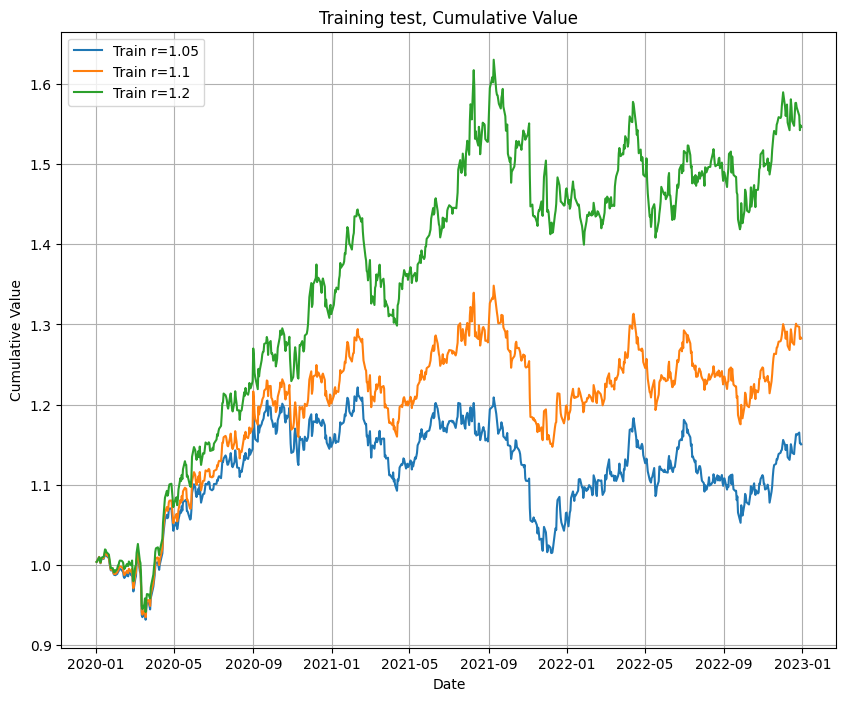

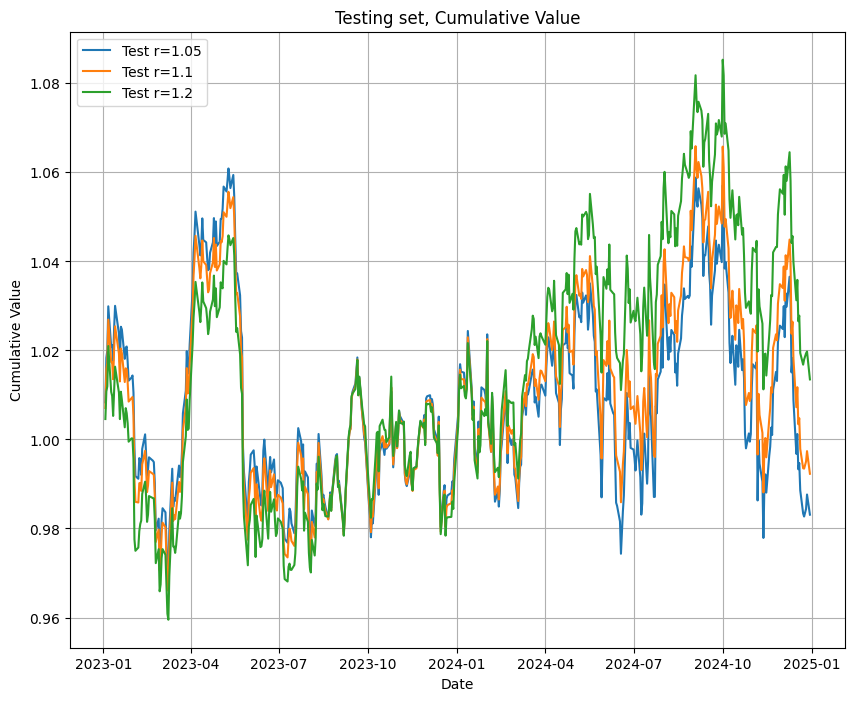

In [279]:
#Plot the cumulative value of each portfolio over time
plt.figure(figsize=(10,8))
for r, res in results.items():
    plt.plot(res['Train: Cumulative value'].index, res['Train: Cumulative value'], label=f'Train r={r}')
plt.title('Training test, Cumulative Value')
plt.ylabel('Cumulative Value')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,8))
for r, res in results.items():
  plt.plot(res['Test: Cumulative value'].index, res['Test: Cumulative value'], label=f'Test r={r}')
plt.title('Testing set, Cumulative Value')
plt.ylabel('Cumulative Value')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

(c) It is well known that optimal portfolios constructed using the
Markowitz procedure perform much more poorly out of sample compared to in sample. This is due to a variety of reasons, one of which is that the procedure assumes that future returns are equal to past returns, another that
the correlation structure of the market might change over time, and
finally, when there are many assets there is the potential for overfitting. Repeat the previous problem but introduce a ridge regression/$l_2$ norm penalty term to the objective function, with a hyperparameter $\lambda$ governing the size of the penalty term.

Specifically, you will select 10 positive values of $\lambda$ on a log scale between $1e-1$ and $10$ and for each value of $\lambda$ solve the following penalized
regression problem:

$$
\begin{aligned}
    \min_{w} w^T(\Gamma+\lambda I) w ,\\
    w^T\mu = r,\\
    \sum_{i=1}^n w_i = 1
\end{aligned}
$$

for just the single value of $r=20\%$. Then calculate the performance
of each of these regularized Markowitz strategies on both the training and test datasets
and plot the the return of the portfolios over both the training and testing period.

For each portfolio, also report:

- The annualized return on the training and test sets;
- The risk on the training and test sets;
- The maximum allocation weight and the asset with maximum allocation;
- The initial leverage

Comment on how the different values of $\lambda$ changed the optimal
portfolios and the difference between in-sample and out-of-sample return and variance.

**Solution:**

In this problem, instead of minimizing $\mathbf{x}^T\Gamma \mathbf{x}$, we minimize $w^T(\Gamma+\lambda I) w$ with the same constraints (target return, sum of weights). In Python, we create 10 positive values of $\lambda$ on a log scale between $1e-1$ and $10$ with np.logspace(). Using similar functions as in part a, we find the portfolio weights (r=1.2) for ten different $\lambda$ values, and apply those weights (without rebalancing) to the training  and testing set. After, we compute metrics for both sets: the cumulative portfolio value over time, the annualized return, the risk, the maximum allocation weight and the asset with maximum allocation, the initial leverage. We also build a training plot to show how each ridge‐regularized portfolio (color‐coded by $\lambda$) evolves in the training period, and a test plot to show how the same portfolios (with their weights fixed from training) perform out of sample from 2023–2024.

Despite aiming for r=1.2, the actual realized annualized return on the training data hovers around ~14–15%, likely due to estimation error, market fluctuations, or portfolio constraints affecting the realized performance. In the test set, it varies from ~16–20%, depending on $\lambda$. While the training variance is fairly stable, the testing annualized returns improve as $\lambda$ grows. As $\lambda$ grows, the portfolio weights shrink in magnitude, reducing extreme bets and short positions, leading to a more diversified allocation. It might be that by penalizing large weights we reduce overfitting and yield more robust out‐of‐sample results.The highest weight belongs to MRNA, with a weight of around 0.005–0.007. With very low
$\lambda$, leverage can exceed 1, indicating some negative weights.

For the training set, all solutions manage a similar final portfolio value around 1.8–1.9× the initial investment by 2022, giving ~14–15% annualized.
For the test set, the unchanging weights are then applied from 2023 onward. Larger‐$\lambda$ portfolios avoid overfitting, posting higher returns (up to ~0.20) and a moderate daily variance. The smaller‐$\lambda$ portfolios typically have more pronounced bets that might not pay off as well out of sample.

Training plot has all ten lines close together, indicating that they end up with a final value near 1.8 or 1.9. The lines nearly overlap because the penalty doesn’t drastically change the in‐sample path. Test plot shows us the results after we applied the same weights to new market data. We see slightly more spread between the lines, especially as $\lambda$ increases.

The ridge regression approach, compared to the solutions in parts (a) and (b), helps mitigate overfitting by penalizing extreme portfolio weights. The risk is not dramatically smaller in training, but the test return is higher. Low $\lambda$ leaves the solution closer to the classic Markowitz approach, with a potential overfitting. Higher $\lambda$ regularizes the portfolio weights, resulting in more stable out‐of‐sample performance and leverage ~1.

In [280]:
#Ridge optimization
def portfolio_optimize_ridge(mu, Gamma, target_return, lam):
    n_companies = len(mu)
    #Ridge-penalized covariance
    Gamma_ridge = Gamma + lam * np.eye(n_companies)

    #Variance
    def portfolio_var(w):
        return w @ Gamma_ridge @ w

    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return},
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    ]

    #Initial condition
    initial_cond = np.array([1/n_companies] * n_companies)

    bounds = tuple((None, None) for _ in range(n_companies))

    #The optimization problem
    result = minimize(portfolio_var, initial_cond, bounds = bounds, method='SLSQP', constraints=constraints)

    return result.x

#0.1 to 10
lambda_val = np.logspace(-1, 1, 10)  # 0.1 to 10
target_return = 1.2
#Keep data
ridge_portfolios = {}
company_name = train_wide.columns

print("For a target return of 1.2: ")
for lam in lambda_val:
    optimal_weights_ridge = portfolio_optimize_ridge(mu, Gamma, target_r, lam)
    ridge_portfolios[lam] = optimal_weights_ridge
    #Print results in readable format
    optimal_weights_ridge_rounded = np.round(optimal_weights_ridge, 4)
    optimal_portfolio_ridge = pd.DataFrame({'Company': company_name, 'Optimal weight': optimal_weights_ridge_rounded})
    print("For lambda: ", lam)
    print(optimal_portfolio_ridge)
    print("Sum of weights, should be 1:", np.sum(optimal_weights_ridge))
    print("Portfolio expected return:", optimal_weights_ridge.T @ mu)

For a target return of 1.2: 
For lambda:  0.1
    Company  Optimal weight
0         A          0.0027
1      AAPL          0.0024
2      ABBV          0.0037
3      ABEV          0.0016
4       ABT          0.0027
..      ...             ...
466     YUM          0.0025
467     ZBH          0.0018
468      ZM          0.0032
469      ZS          0.0030
470     ZTS          0.0022

[471 rows x 2 columns]
Sum of weights, should be 1: 0.9999999999999998
Portfolio expected return: 1.2000000000442987
For lambda:  0.16681005372000587
    Company  Optimal weight
0         A          0.0026
1      AAPL          0.0024
2      ABBV          0.0033
3      ABEV          0.0015
4       ABT          0.0025
..      ...             ...
466     YUM          0.0024
467     ZBH          0.0018
468      ZM          0.0027
469      ZS          0.0029
470     ZTS          0.0021

[471 rows x 2 columns]
Sum of weights, should be 1: 1.0
Portfolio expected return: 1.1999999999973467
For lambda:  0.2782559402207

In [281]:
#Cumulative portfolio value
def cumulative_value(weights, returns_weights):
    #cumulative product over time for each asset
    cumprod_val = returns_weights.cumprod()
    #daily portfolio value
    cumul_val = cumprod_val.dot(weights)
    return cumul_val

#Annualized return
def annualized_return(cumul_val):
    T = len(cumul_val)
    #the final cumulative value of the portfolio at day T
    final_val = cumul_val.iloc[-1]
    #assume there are 252 trading days in a year
    return final_val**(252/T) - 1

#Realized variance of the daily return
def realized_var(cumul_val):
    daily_ret = cumul_val.pct_change()
    return daily_ret.var()

#Apply to training and test sets for each portfolio
results_ridge = {}

for lam, optim_weights in ridge_portfolios.items():
    #Cumulative portfolio value
    train_cumul_val = cumulative_value(optim_weights, train_wide_ret)
    test_cumul_val  = cumulative_value(optim_weights, test_wide_ret)

    #Annualized return
    ann_ret_train = annualized_return(train_cumul_val)
    ann_ret_test  = annualized_return(test_cumul_val)

    #Realized variance
    var_train = realized_var(train_cumul_val)
    var_test  = realized_var(test_cumul_val)

    #Maximum allocation
    names_cols = train_wide_ret.columns
    max_idx = np.argmax(optim_weights)
    max_asset = names_cols[max_idx]
    max_weight = optim_weights[max_idx]
    #sum of absolute weights
    leverage = np.sum(np.abs(optim_weights))

    # Store
    results_ridge[lam] = {
        'Optimal weights': optim_weights,
        'Train: Cumulative value': train_cumul_val,
        'Test: Cumulative value': test_cumul_val,
        'Train: Annualized return': ann_ret_train,
        'Test: Annualized return': ann_ret_test,
        'Train: Realized variance': var_train,
        'Test: Realized variance': var_test,
        'Asset with the maximum allocation weight': max_asset,
        'Its weight': max_weight,
        'The initial leverage': leverage
    }

#Print metrics
for t, r in results_ridge.items():
    print("For lambda", t)
    print("Training annualized return:", np.round(r['Train: Annualized return'], 4))
    print("Training risk (variance):", np.round(r['Train: Realized variance'], 6))
    print("Testing annualized return:", np.round(r['Test: Annualized return'], 4))
    print("Testing risk (variance):", np.round(r['Test: Realized variance'], 6))
    print("Max-weight asset:", r['Asset with the maximum allocation weight'], "with weight", np.round(r['Its weight'], 4))
    print("Initial leverage:", np.round(r['The initial leverage'], 4))

For lambda 0.1
Training annualized return: 0.1458
Training risk (variance): 0.000222
Testing annualized return: 0.1667
Testing risk (variance): 5.1e-05
Max-weight asset: MRNA with weight 0.007
Initial leverage: 1.0068
For lambda 0.16681005372000587
Training annualized return: 0.1458
Training risk (variance): 0.000238
Testing annualized return: 0.1779
Testing risk (variance): 5.5e-05
Max-weight asset: MRNA with weight 0.0065
Initial leverage: 1.0028
For lambda 0.2782559402207124
Training annualized return: 0.1458
Training risk (variance): 0.000252
Testing annualized return: 0.1874
Testing risk (variance): 5.9e-05
Max-weight asset: MRNA with weight 0.0062
Initial leverage: 1.0005
For lambda 0.46415888336127786
Training annualized return: 0.1458
Training risk (variance): 0.000257
Testing annualized return: 0.1907
Testing risk (variance): 6.1e-05
Max-weight asset: MRNA with weight 0.006
Initial leverage: 1.0
For lambda 0.774263682681127
Training annualized return: 0.1458
Training risk (var

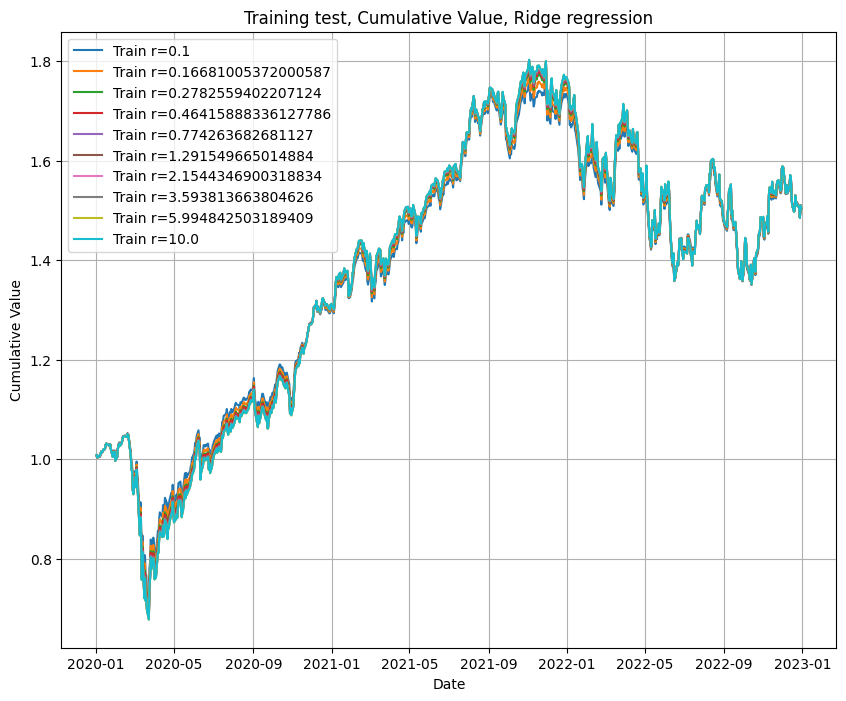

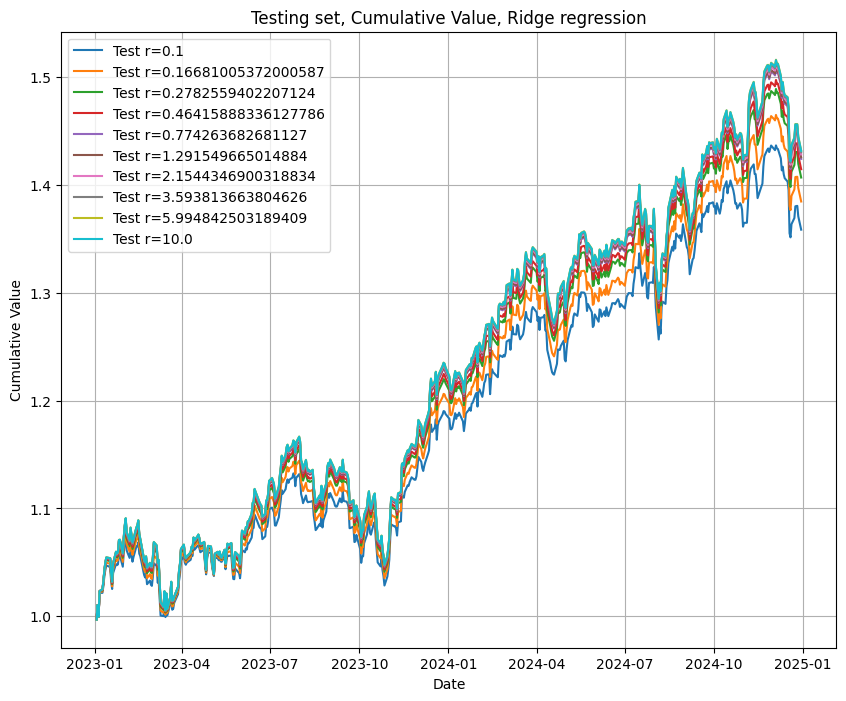

In [282]:
#Plot the cumulative value of each portfolio over time
plt.figure(figsize=(10,8))
for r, res in results_ridge.items():
    plt.plot(res['Train: Cumulative value'].index, res['Train: Cumulative value'], label=f'Train r={r}')
plt.title('Training test, Cumulative Value, Ridge regression')
plt.ylabel('Cumulative Value')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,8))
for r, res in results_ridge.items():
  plt.plot(res['Test: Cumulative value'].index, res['Test: Cumulative value'], label=f'Test r={r}')
plt.title('Testing set, Cumulative Value, Ridge regression')
plt.ylabel('Cumulative Value')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# Reference

1. Boyd, S. (2018). *Introduction to applied linear algebra: Vectors, matrices, and least squares*. Cambridge University Press. https://web.stanford.edu/~boyd/vmls/vmls.pdf

2. Boyd, S., & Vandenberghe, L. (2004). *Convex optimization*. Cambridge University Press. https://doi.org/10.1017/CBO9780511804441

https://docs.mosek.com/latest/pythonfusion/case-studies-portfolio.html

https://docs.mosek.com/portfolio-cookbook/markowitz.html

https://medium.com/@ethan.duong1120/python-powered-portfolio-optimization-achieving-target-returns-through-weight-optimization-fc5163e5c9c6

https://medium.com/@guilherme.ziegler/constructing-markowitzs-efficient-frontier-with-python-and-streamlit-f99a495fb74d
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html